In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datetime, time
import sklearn, sklearn.metrics, sklearn.preprocessing, sklearn.linear_model, sklearn.ensemble, sklearn.model_selection

import modutils

data_dir = '../DataSets/MercariPrice/'
src_file = data_dir + 'train.tsv' 
dst_file = data_dir + 'train_simple.csv'

In [2]:
src = pd.read_csv(src_file, '\t')

In [3]:
src['cat1'] = src.category_name.map(lambda x: x.split('/')[0].replace('\'','') if type(x) is str and len(x.split('/')) > 0 else 'NONE')
src['cat2'] = src.category_name.map(lambda x: x.split('/')[1].replace('\'','') if type(x) is str and len(x.split('/')) > 1 else 'NONE')
src['cat3'] = src.category_name.map(lambda x: x.split('/')[2].replace('\'','') if type(x) is str and len(x.split('/')) > 2 else 'NONE')
src['cat4'] = src.category_name.map(lambda x: x.split('/')[3].replace('\'','') if type(x) is str and len(x.split('/')) > 3 else 'NONE')
src['cat5'] = src.category_name.map(lambda x: x.split('/')[4].replace('\'','') if type(x) is str and len(x.split('/')) > 4 else 'NONE')
src['cat1g'] = src.cat1
src['cat2g'] = src.cat1g + '/' + src.cat2
src['cat3g'] = src.cat2g + '/' + src.cat3
src['cat4g'] = src.cat3g + '/' + src.cat4
src['brand'] = src.brand_name.map(lambda x: x.replace('\'','') if type(x) is str else 'NONE')

src_brands = src.brand.value_counts()
src_cat3gs = src.cat3g.value_counts()
src_cat4gs = src.cat4g.value_counts()

In [4]:
%%time
brands_hit5k = set(src_brands[(src_brands > 5000)&(src_brands.index != 'NONE')].index)
brands_hit1k = set(src_brands[(src_brands > 1000)&(src_brands.index != 'NONE')].index)
brands_hit200 = set(src_brands[(src_brands > 200)&(src_brands.index != 'NONE')].index)

cat3g_hit100 = set(src_cat3gs[(src_cat3gs > 100)].index)
cat3g_hit500 = set(src_cat3gs[(src_cat3gs > 500)].index)
cat4g_hit100 = set(src_cat4gs[(src_cat4gs > 100)].index)

src['brand_5k'] = src.brand.map(lambda x: x if x in brands_hit5k else 'OTHER')
src['brand_1k'] = src.brand.map(lambda x: x if x in brands_hit1k else 'OTHER')
src['brand_200'] = src.brand.map(lambda x: x if x in brands_hit200 else 'OTHER')

src['cat3g_100'] = src.cat3g.map(lambda x: x if x in cat3g_hit100 else 'OTHER')
src['cat3g_500'] = src.cat3g.map(lambda x: x if x in cat3g_hit500 else 'OTHER')
src['cat4g_100'] = src.cat4g.map(lambda x: x if x in cat4g_hit100 else 'OTHER')

Wall time: 800 ms


In [5]:
np.sum(src.cat3g.value_counts()>500)

210

In [6]:
len(src.cat3g_500.value_counts())

211

In [7]:
%%time
fx_brand = sklearn.preprocessing.LabelBinarizer().fit_transform(src.brand_1k)
fx_cat1 = sklearn.preprocessing.LabelBinarizer().fit_transform(src.cat1g)
fx_cat2 = sklearn.preprocessing.LabelBinarizer().fit_transform(src.cat2g)
fx_cat3 = sklearn.preprocessing.LabelBinarizer().fit_transform(src.cat3g_500)
fx_cond = sklearn.preprocessing.LabelBinarizer().fit_transform(src.item_condition_id)
fx_ship = src.shipping.values.reshape(-1,1)

X = np.hstack([fx_brand, fx_cat1, fx_cat2, fx_cat3, fx_cond, fx_ship])
Y = np.log(1 + src.price.values)

Wall time: 16.6 s


In [8]:
X.shape

(593376, 425)

In [9]:
%%time
(Xtrain, Ytrain), (Xvalid, Yvalid), (Xtest, Ytest) = modutils.splitSample((X, Y), pcts = [0.4,0.3,0.3])

Wall time: 657 ms


In [10]:
Y.shape

(593376,)

In [11]:
%%time
m_linreg_1k_12g_3g500 = sklearn.linear_model.LassoCV().fit(Xtrain, Ytrain)

Wall time: 1min 31s


In [12]:
sklearn.metrics.r2_score(Yvalid, m_linreg_1k_12g_3g500.predict(Xvalid))

0.32982905285825592

In [13]:
%%time
m_gradboost = sklearn.ensemble.GradientBoostingRegressor(min_samples_leaf=10).fit(Xtrain, Ytrain)

Wall time: 7min 28s


In [14]:
sklearn.metrics.r2_score(Yvalid, m_gradboost.predict(Xvalid))

0.26125550919661111

In [15]:
Yf = m_linreg_1k_12g_3g500.predict(X)

In [16]:
src['fcst_simple'] = Yf
src['fcst_diff_simple'] = np.log(1 + src.price) -src.fcst_simple

In [17]:
src.describe()

,train_id,item_condition_id,price,shipping,fcst_simple,fcst_diff_simple
count,593376.000000,593376.000000,593376.000000,593376.000000,593376.000000,593376.000000
mean,296687.500000,1.907738,26.689003,0.446294,2.978967,-0.000393
std,171293.041002,0.902921,38.340061,0.497108,0.417568,0.612034
min,0.000000,1.000000,0.000000,0.000000,1.592800,-4.782042
25%,148343.750000,1.000000,10.000000,0.000000,2.707269,-0.405822
50%,296687.500000,2.000000,17.000000,0.000000,2.916923,-0.055312
75%,445031.250000,3.000000,29.000000,1.000000,3.192107,0.340884
max,593375.000000,5.000000,2000.000000,1.000000,5.527510,4.625071


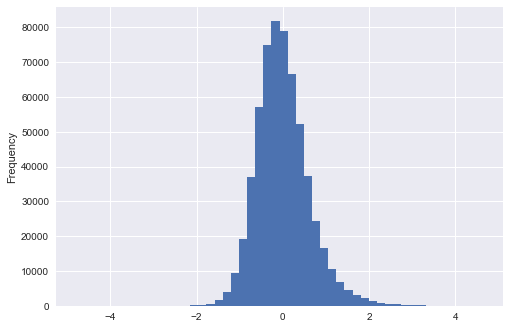

In [18]:
src.fcst_diff_simple.plot.hist(bins=50)
plt.show()

In [20]:
src.to_csv(dst_file, index=False,  encoding='utf-8')

In [ ]:
len(src)